## Titanic (Kaggle)

The contents within this notebook function as a personal knowledge base derived from the information presented on [this](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions) page. To obtain the corresponding CSV files, visit the [associated](https://www.kaggle.com/c/titanic/data) website.

In this experimental setting, as `test_df` is provided, we include this in our analysis. In practice, we would not inlcude `test_df` to prevent data leakage and as it is likely not available

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rnd
from sklearn.svm import SVC

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combined_df = pd.concat([train_df, test_df], axis = 0, ignore_index=True)

In [3]:
combined_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Analyze by describing the data
- Which features are available in the data?
- Which features are categorical (nominal, ordinal, ratio or interval based)?
    - Survived, Sex, Embarked
    - Categorical (ordinal): Pclass
- Which features are numerical (discrete, coninuous, timeseries based)?
    - Continuous: Age, Fare
    - Discrete: SibSp, Parch
- Which features are mixed data types?
    - Mix of numeric and alpha numeric: Ticket
    - Alphanumeric: Cabin
- Which features may contain errors or typos?
    - Use `value_counts()`, to counts for occurences per category
    - Use `sort_values()`, to spot outliers for numerical values
    - Use `hist()`, to get an idea on the distribution of the data
    - etc.
- Which features contain blank, null or empty values? e.g. `train_df.isnull().sum()`
    - `train_df`: Cabin, Age, embarked
    - `test_df`: Cabin, Age
- What are the datatypes of the features? e.g. `df.info()`
    - `train_df` & `test_df`: 6 float or int, 5 strings (object)
- Roughly checking the distributions per (numerical) feature using `df.describe()`
    - ~38% survived
    - 75% of the passengers was younger than 38 years old
    - Most passengers did not travel with childeren
    - Someone payed 512 for their ticket
- Rougly checking the distribution for categorical features using `df.describe(include=['O'])`
    - All names are unique
    - There are more male's than female's (577/891)
    - There are many duplicated ticket values, people onboarded using a group ticket?
    - People shared a cabin, max people who did this were 4
    - Three starting ports, 'S' was most popular

In [4]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Conclusion based on preliminary data analysis

- **Correlating**, we want to further investigate how well each feature correlates to `Survival`
- **Completing**, For `Age` and `Embarked`, we found missing values, while these features might contain valuable information, hence, imputing is required
- **Correcting**, `Ticket`, `Cabin`, `PassengerId` will be dropped as it is unlikely these features will contain useful information. 
- **Creating**
    - We can create a `family_total` feature by combining features `Parch` and `SibSp`. 
    - From `Name`, we can extract `Title`, which could be valuable
    - I am considering to keep `Name`, to transform the feature to `name_length`, especially in those days, this might say something about your status, and therefore chances of survival.
    - Suggested in example notebook: "*We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature*" -> Probably related to binning.
    - Suggested in example notebook: "*We may also want to create a Fare range feature if it helps our analysis*" -> Probably related to binning.
- **Classifying**, not sure what purpose this serves in the [example notebook](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions), it looks like the author is formulating some hypotheses for testing purposes

### Analyze by pivoting features
- Checking for some categorical features what the chances of survival are per class

In [7]:
train_df[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [8]:
train_df[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


## Analyze by visualizing the data

### Checking numerical features
- Chances of surviving are a lot higher for age < 10
- Age doesn't follow a gaussian distribution; there we're a lot of people younger than 4
- Some very old people (Age ~80), took their chance and jumped in the life boats
- A lot of people in the group of Age between 20-30 did not survive
- Most people are aged between 17 and 37

Conclusions
- We should consider `Age` in our analysis
- We could optionally apply binning for `Age`

<AxesSubplot: xlabel='Age', ylabel='Count'>

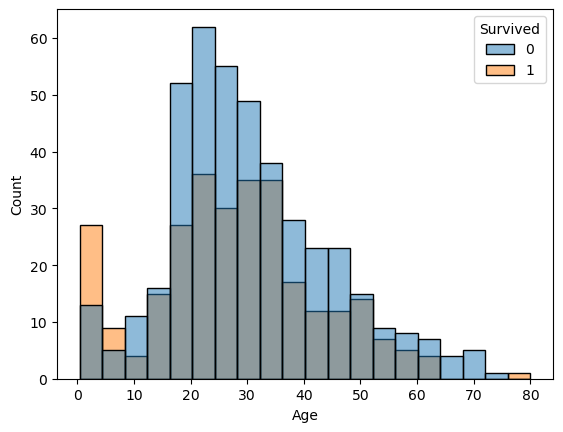

In [9]:
sns.histplot(data= train_df, x='Age', hue='Survived', bins=20)

### Checking ordinal features

- Class 3 contains most people that did not survive
- Class 1 has the highest number of survivors
- `Age` distributions in `Pclass` seem to vary; the higher the class the younger the population

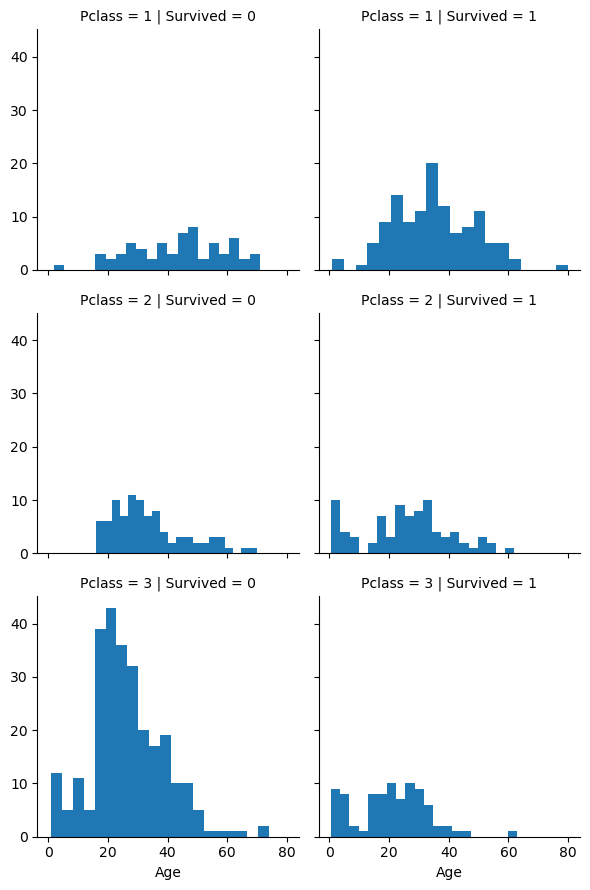

In [10]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', bins=20)

### Correlating categorical features

- Female passengers that embarked from Q and S were significantly more likely to survive than male passengers
- The opposite was applicable for people that embarked at C: could it be that `Embarked` is highly correlated with a feature that is not visible in the plot, e.g. `Age` that correlates to `Survived`
- In general: The higher the class, the lower the chances of survival, except for males that embarked from Q; could it be that no males from class 1 & 2 embarked from Q,

c:\Users\LuukvanRoessel\Anaconda3\envs\ml-luuk\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\LuukvanRoessel\Anaconda3\envs\ml-luuk\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


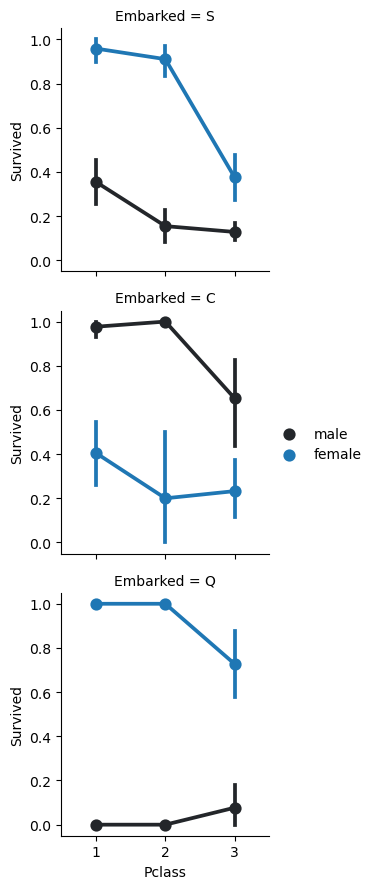

In [11]:
grid = sns.FacetGrid(train_df, row= "Embarked")
grid.map(sns.pointplot, "Pclass", "Survived", "Sex")
grid.add_legend()

- Fares for C were highest
- Fares for Q were lowest
- People that departed from C and survived payed on average more for their tickets than people that also embarked from C but had a lower fare. (Also visible for other `Embarked` categories)
- for most situations, females payed more for their tickets than males
- 


c:\Users\LuukvanRoessel\Anaconda3\envs\ml-luuk\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


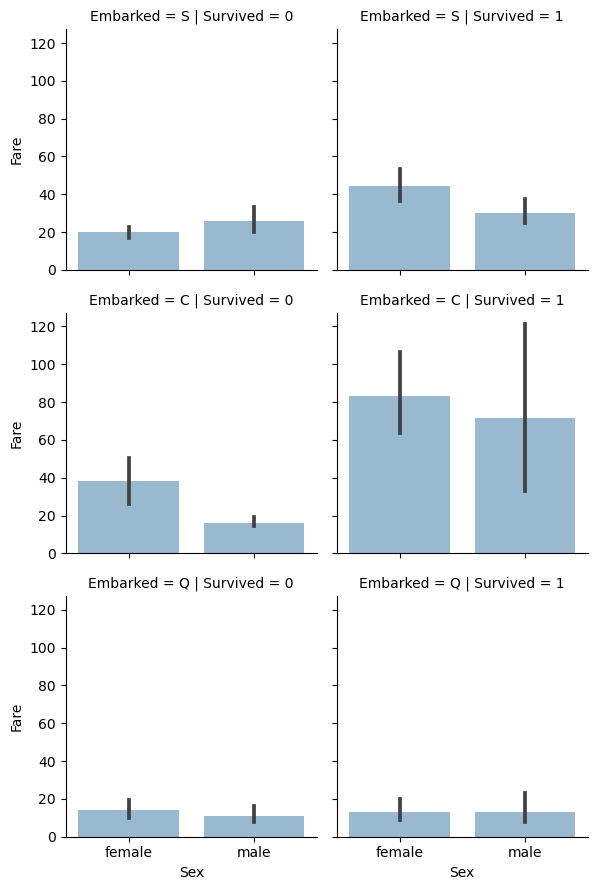

In [12]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5)
grid.add_legend()

### Wrangle data (correcting, creating and completing data)

- Correcting by dropping features
- Creating new features from existing
- Converting categorical features
- Completing numerical continuous features
- Creating new features by combining existing features
- Completing a categorical feature
- Converting categorical features to numeric
- "Quick completing and converting a numeric feature"

#### Dropping features

In [13]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

### Engineering new title feature
1. extrating titles from name
2. Grouping rare titles into single 'rare' group, and group titles with similar definitions
3. Ordinal mapping
4. Dropping Name and PassengerID

In [14]:
# extract title from name
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Groupe rare title into rare, group titles with similar definitions
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Ordinal mapping
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

# Drop Name and PassengerId
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

#### Converting a categorical value (Sex)

necessary as some methods require numeric input

In [15]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

#### Completing a numerical coninuous feature (Age)
1. A simple way of imputing is adding random numbers between the mean and standard deviation
2. A more accurate way is to impute age by checking median values for correlated features like `Pclass` and `Sex`
3. Combination of 1 and 2: determine mean and std for sets of `Pclass` and `Sex`
4. (Optional) Applying age bands

In [16]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_mean = guess_df.mean()
            age_std = guess_df.std()
            age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            # age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [17]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.346899
2,"(32.0, 48.0]",0.394872
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [18]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

#### Create a new feature, `FamilySize` and `IsAlone` from `Parch` and `SibSp`

After analysis, we decide to drop `Familysize`, `Parch` and `SibSp`

In [19]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

print(train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print(train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [20]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

### Combining `Pclass` and `Age`

In [21]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


#### Imputing for categorical feature `Embarked`

In [22]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#### Processing the `Fare` feature

In [23]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

### Model, predict and solve

Quickly selecting a support vector machine as out prediction method to check performance

In [27]:
svc = SVC()
svc.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
Y_pred = svc.predict(test_df.drop('PassengerId', axis=1))
acc_svc = round(svc.score(train_df.drop('Survived', axis=1), train_df['Survived']) * 100, 2)
print(f"The accuracy of the model is {acc_svc}%, the kernel used is {svc.kernel}")
acc_svc

The accuracy of the model is 78.23%, the kernel used is rbf


78.23